# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas import Series

%matplotlib inline


In [3]:
# Import passengers.csv and set it as a time-series object. Plot the TS
passengers = pd.read_csv('passengers.csv')
passengers.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [5]:
#set object date an index
passengers['Month'] = pd.to_datetime(passengers['Month'])
passengers.set_index('Month', inplace=True)

print(passengers.head())
print(passengers.index)

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)


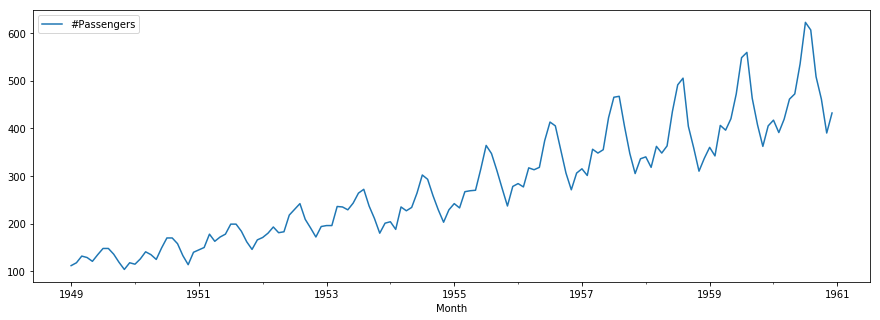

In [6]:
passengers.plot(figsize=(15,5))

## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [7]:
from statsmodels.tsa.stattools import adfuller

In [10]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab

def stationarity (ts):
    
    #Rolling statistics
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()
    
    #Plot rolling stats
    plt.figure(figsize=(15,5))
    orig = plt.plot(ts, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standar Deviation')
    plt.show()
    
    #Dickey-Fuller test:
    dftest = adfuller(ts['#Passengers'])
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print("Results of Dickey-Fuller Test:")
    print(dfoutput)
    
    return 0

Use your newly created function on the airpassenger data set.

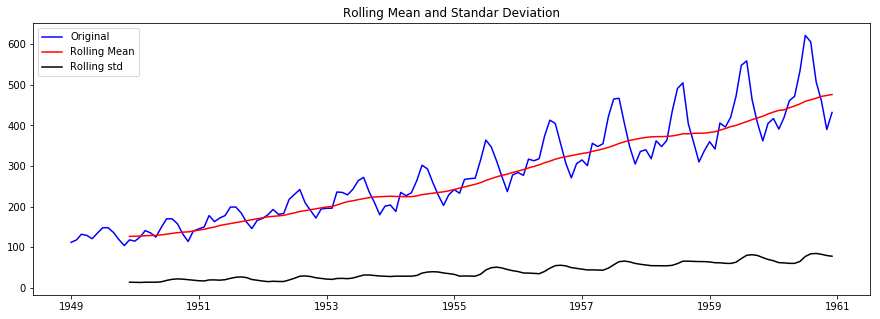

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


0

In [11]:
stationarity(passengers)

## Perform a log() and sqrt() transform

In [12]:
# Log transform timeseries and compare with original to check the effect

ts_log = np.log(passengers)
ts_sqrt = np.sqrt(passengers)

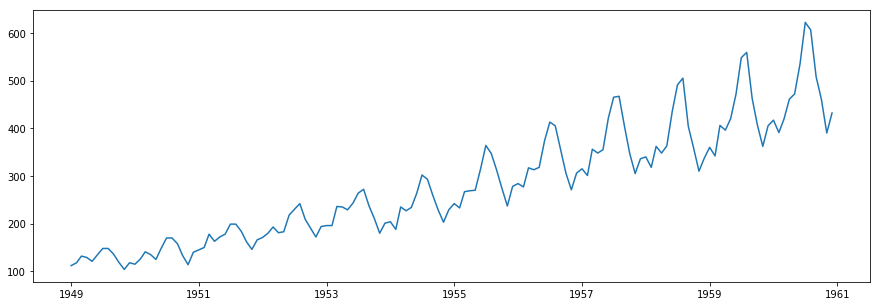

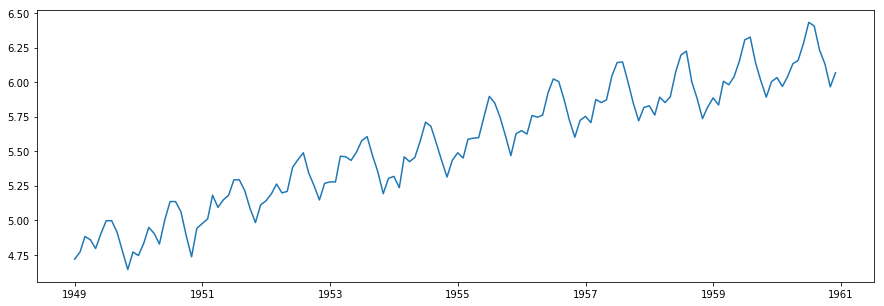

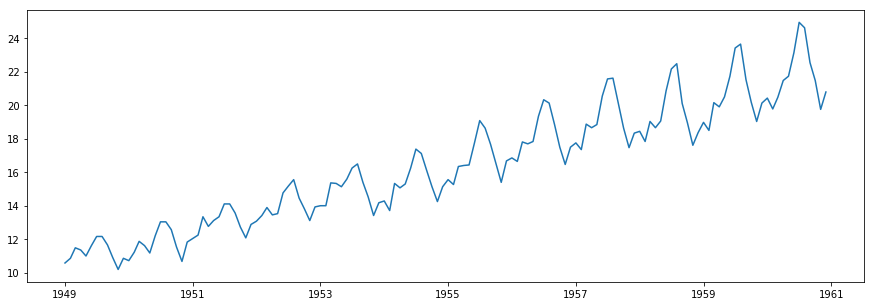

In [15]:
plt.figure(figsize=(15,5))
plt.plot(passengers);
plt.show()

plt.figure(figsize=(15,5))
plt.plot(ts_log);
plt.show()

plt.figure(figsize=(15,5))
plt.plot(ts_sqrt)
plt.show()



moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

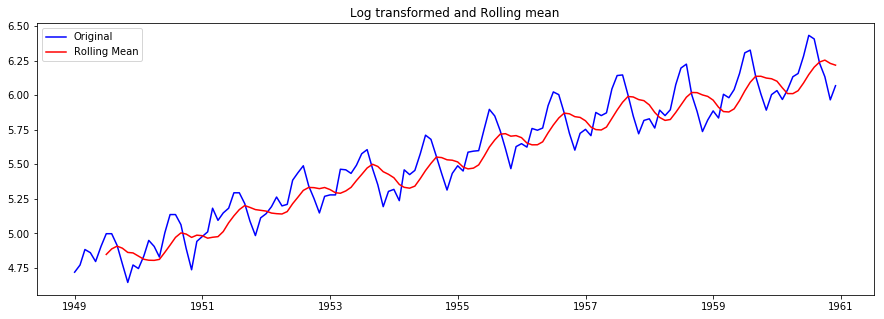

In [18]:
rolmean = ts_log.rolling(window=7).mean()

plt.figure(figsize=(15,5))
orig = plt.plot(ts_log, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Log transformed and Rolling mean')

plt.show()

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [24]:
# Subtract the moving average from the original data and check head for Nans
data_minus_rolmean = ts_log - rolmean
data_minus_rolmean.head(10)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,0.150059
1949-08-01,0.110242
1949-09-01,0.005404


In [25]:
# Drop the NaN values from timeseries calculated above
data_minus_rolmean.dropna(inplace=True)

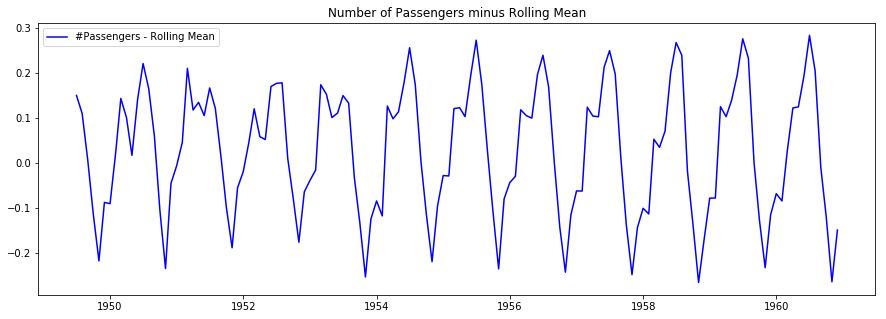

In [27]:
# Plot the result
plt.figure(figsize=(15,5))
plt.plot(data_minus_rolmean, color='blue', label='#Passengers - Rolling Mean')
plt.legend(loc='best')
plt.title('Number of Passengers minus Rolling Mean')

plt.show()

Finally, use your function `check_stationarity` to see if this series is considered stationary!

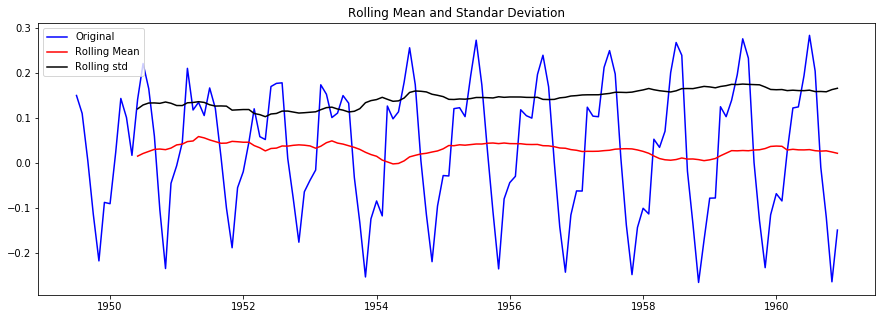

Results of Dickey-Fuller Test:
Test Statistic                  -2.348027
p-value                          0.156946
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


0

In [28]:
stationarity(data_minus_rolmean)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?
Not stationary: p-value >> 0.05

## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

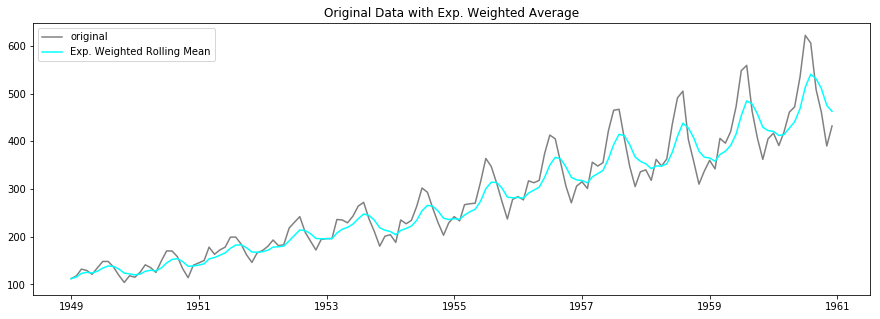

In [33]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
exp_rolmean = passengers.ewm(halflife=2).mean()     #Must pass one of comass, span, halflife, or alpha in ewm()

# Plot the original data with exp weighted average
plt.figure(figsize=(15,5))
orig = plt.plot(passengers, color='gray', label='original')
exp = plt.plot(exp_rolmean, color='cyan', label='Exp. Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Original Data with Exp. Weighted Average')
plt.show()

In [34]:
# Subtract the moving average from the original data and plot
data_minus_exprolmean = passengers - exp_rolmean
data_minus_exprolmean.head()

,#Passengers
Month,
1949-01-01,0.000000
1949-02-01,2.485281
1949-03-01,9.016100
1949-04-01,3.666667
1949-05-01,-2.791584


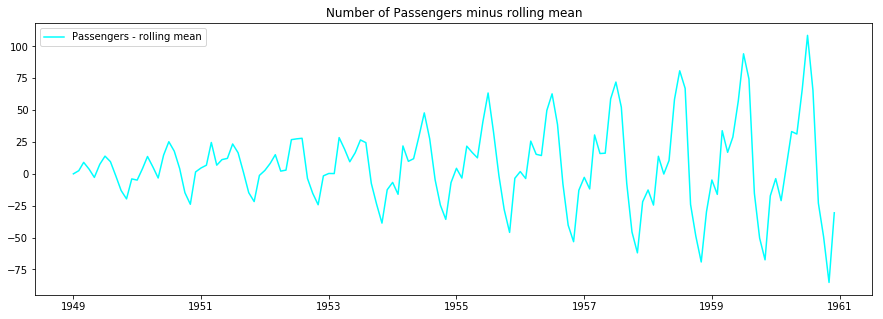

In [36]:
plt.figure(figsize=(15,5))
plt.plot(data_minus_exprolmean, color='cyan',label='Passengers - rolling mean')
plt.legend(loc='best')
plt.title('Number of Passengers minus rolling mean')
plt.show()

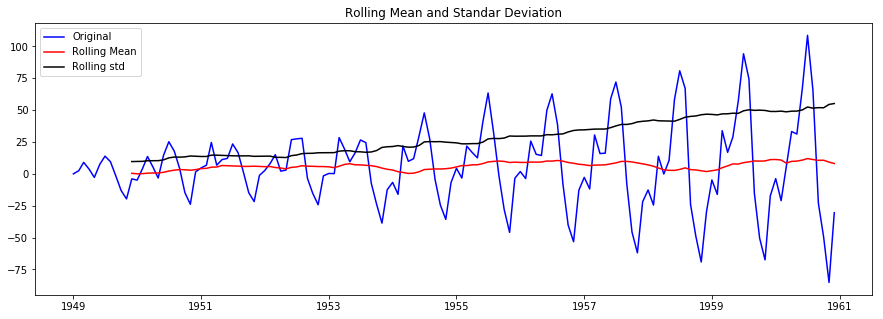

Results of Dickey-Fuller Test:
Test Statistic                  -2.784213
p-value                          0.060564
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


0

In [37]:
# do a stationarity check
stationarity(data_minus_exprolmean)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?
Low stationarity, p-value is almost 0.05 (just over it)

## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [38]:
# difference your data and look at the head
data_diff = passengers.diff(periods=12)   #number of passengers/month, periods=12
data_diff.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


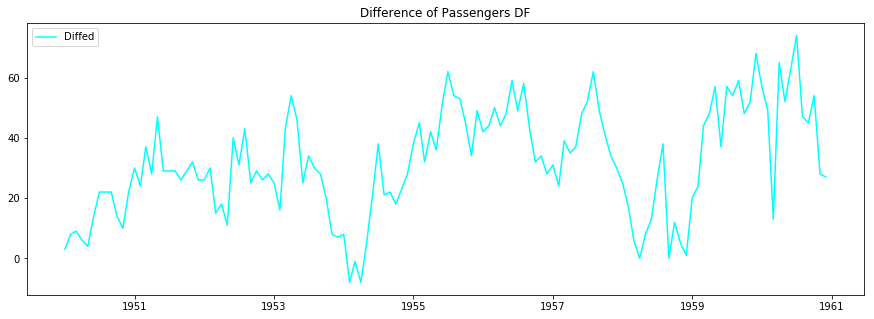

In [39]:
# plot your differenced time series
plt.figure(figsize=(15,5))
plt.plot(data_diff, color='cyan',label='Diffed')
plt.legend(loc='best')
plt.title('Difference of Passengers DF')
plt.show()

In [40]:
# drop nas
data_diff.dropna(inplace=True)

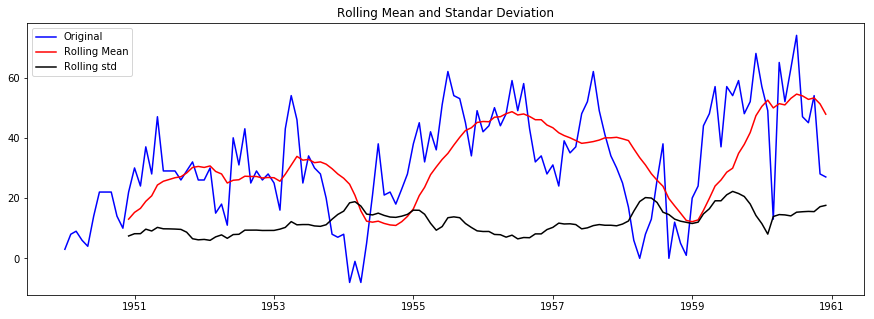

Results of Dickey-Fuller Test:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


0

In [41]:
# perform the stationarity check
stationarity(data_diff)

### Your conclusion
P-value below 0.05, 

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.